# Import Library

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import logging
from itertools import product
import networkx as nx

logging.basicConfig(level=logging.INFO)

# Load dataset

In [98]:
df = pd.read_csv('data/Cleaned_Student_performance_data.csv')
logging.info(f"Dataset shape: {df.shape}")

INFO:root:Dataset shape: (2392, 15)


# Analyze dataset

INFO:root:Descriptive statistics:
INFO:root:         StudentID          Age       Gender    Ethnicity  ParentalEducation  \
count  2392.000000  2392.000000  2392.000000  2392.000000        2392.000000   
mean   2196.500000    16.468645     0.510870     0.877508           1.746237   
std     690.655244     1.123798     0.499986     1.028476           1.000411   
min    1001.000000    15.000000     0.000000     0.000000           0.000000   
25%    1598.750000    15.000000     0.000000     0.000000           1.000000   
50%    2196.500000    16.000000     1.000000     0.000000           2.000000   
75%    2794.250000    17.000000     1.000000     2.000000           2.000000   
max    3392.000000    18.000000     1.000000     3.000000           4.000000   

       StudyTimeWeekly     Absences     Tutoring  ParentalSupport  \
count      2392.000000  2392.000000  2392.000000      2392.000000   
mean          9.772199    14.541388     0.301421         2.122074   
std           5.652105     8

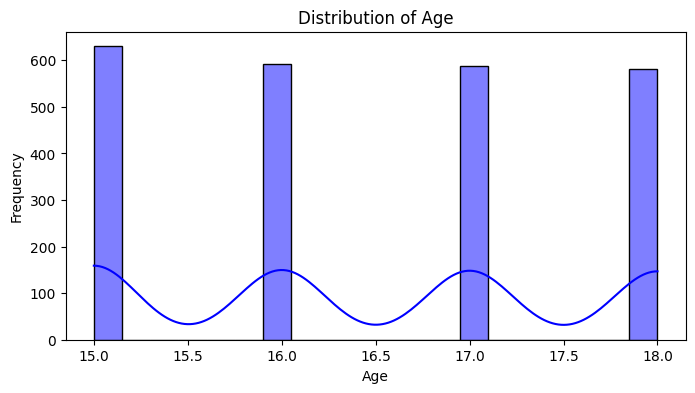

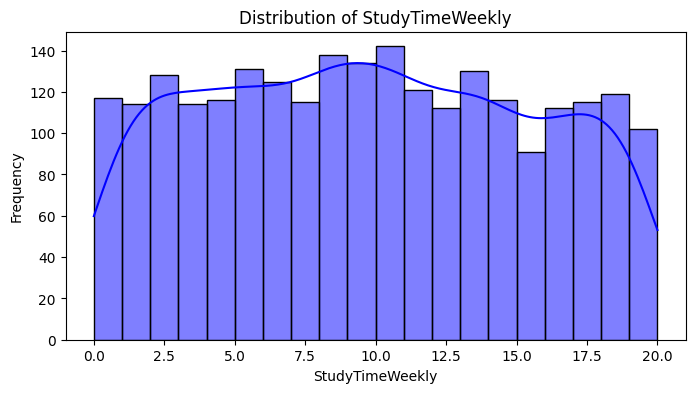

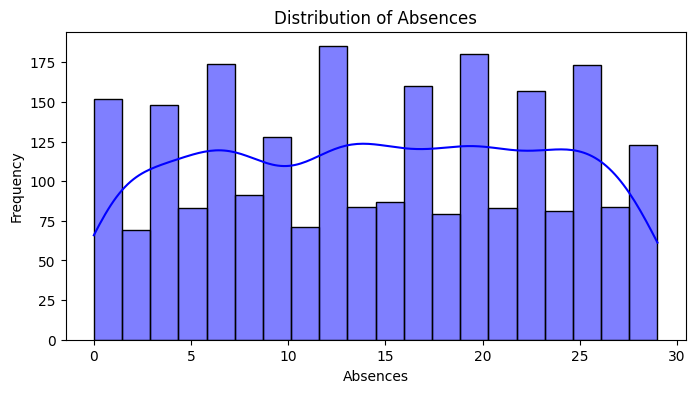

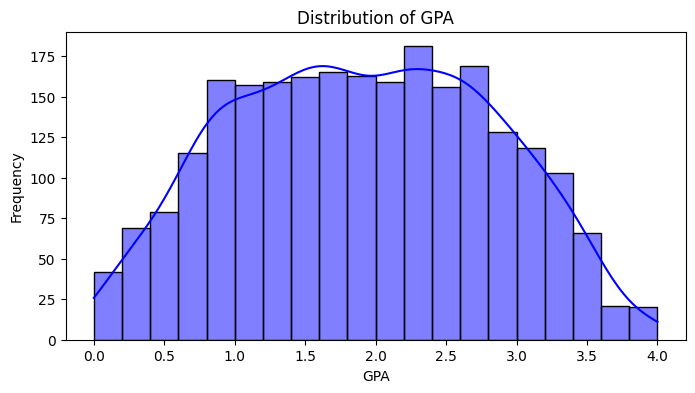

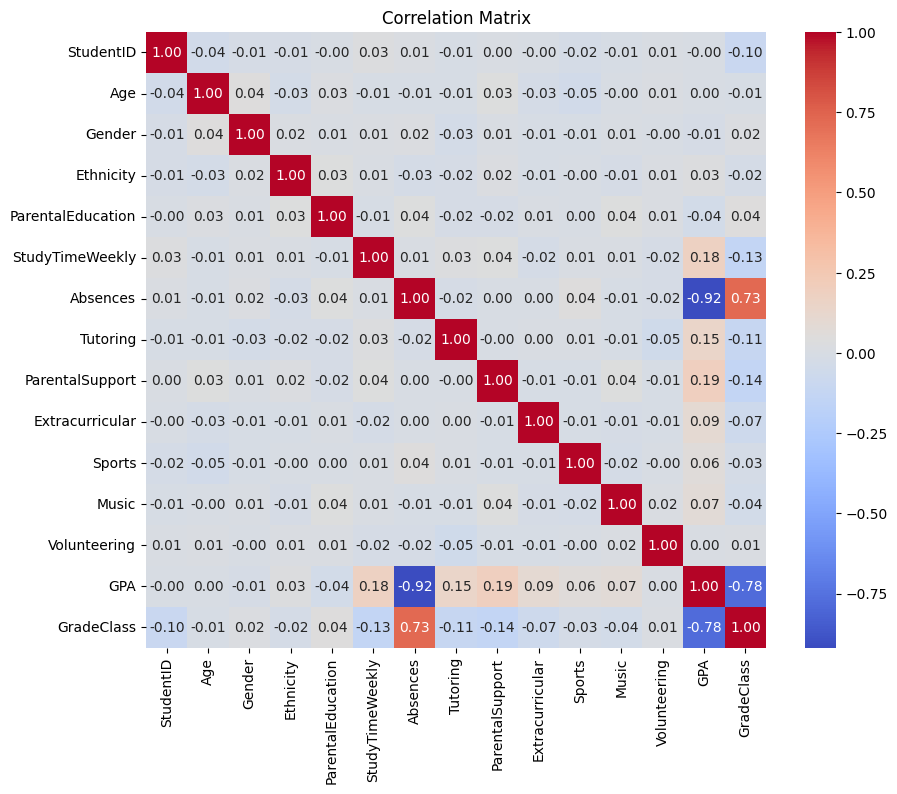

In [ ]:
# Descriptive statistics
logging.info("Descriptive statistics:")
logging.info(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
logging.info(f"Missing values:\n{missing_values}")

# Handle missing values (if any)
df.fillna(df.median(), inplace=True)  # Replace missing values with median

# Visualize distributions of numerical features
numerical_cols = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Discretize continuous features

In [100]:
gpa_bins   = [0, 1.0, 2.0, 3.0, 4.0]
gpa_labels = ['VeryLow', 'Low', 'Medium', 'High']
df['GPA_bin'] = pd.cut(df['GPA'], bins=gpa_bins, labels=gpa_labels, include_lowest=True)

study_bins   = [0, 5, 10, 15, 20, np.inf]
study_labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
df['Study_bin'] = pd.cut(df['StudyTimeWeekly'], bins=study_bins, labels=study_labels, include_lowest=True)

abs_bins   = [0, 5, 10, 15, 20, np.inf]
abs_labels = ['None', 'Few', 'Moderate', 'High', 'VeryHigh']
df['Absences_bin'] = pd.cut(df['Absences'], bins=abs_bins, labels=abs_labels, include_lowest=True)

# Encode categorical variables

In [ ]:
categorical_cols = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 
    'Extracurricular', 'Study_bin', 'Absences_bin', 'GPA_bin', 'GradeClass'
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature selection and data split

In [ ]:
features = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Study_bin', 'Absences_bin', 
    'Tutoring', 'ParentalSupport', 'Extracurricular'
]
target_gpa   = 'GPA_bin'
target_class = 'GradeClass'

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[target_class]
)

# Define Bayesian Network structure

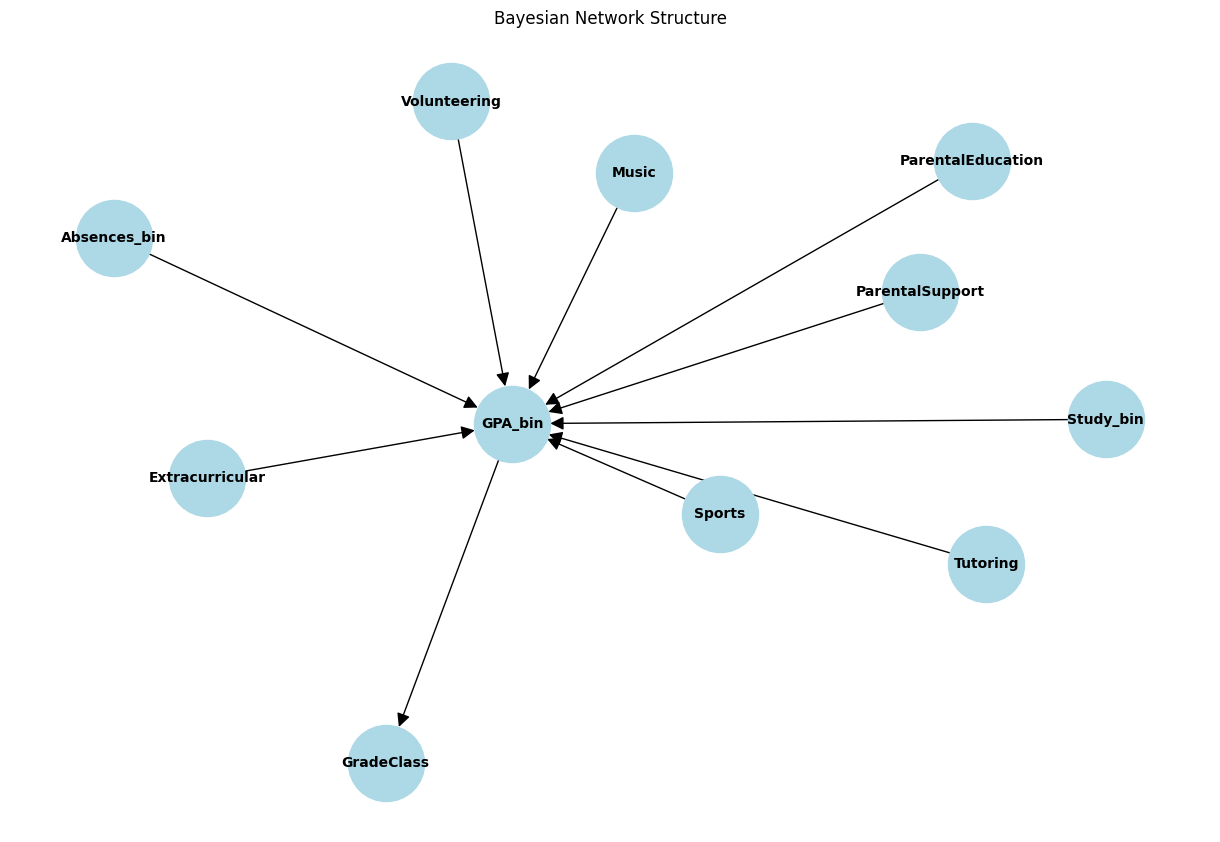

In [ ]:
parents = {
    'Gender': [],
    'Ethnicity': [],
    'ParentalEducation': [],
    'Tutoring': [],
    'ParentalSupport': [],
    'Extracurricular': [],
    'Study_bin': [],
    'Absences_bin': [],
    'GPA_bin': ['Study_bin', 'ParentalEducation', 'Absences_bin', 'Tutoring'],
    'GradeClass': ['GPA_bin', 'ParentalSupport', 'Extracurricular']
}

# Visualize Bayesian Network structure
def visualize_bayesian_network(parents):
    G = nx.DiGraph()
    for child, pars in parents.items():
        for parent in pars:
            G.add_edge(parent, child)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
    plt.title("Bayesian Network Structure")
    plt.show()

visualize_bayesian_network(parents)

# Compute Conditional Probability Tables (CPTs)

In [ ]:
CPT = {}

# Hyperparameters
laplace_smoothing = 1  # Smoothing factor
min_data_threshold = 5  # Minimum data points required for a combination

for node, pars in parents.items():
    if not pars:
        # For nodes without parents, calculate prior probabilities
        CPT[node] = train_df[node].value_counts(normalize=True).to_dict()
    else:
        # For nodes with parents, calculate conditional probabilities
        parent_values = [train_df[p].unique() for p in pars]
        combinations = list(product(*parent_values))
        table = {}
        classes = train_df[node].unique()

        for combo in combinations:
            # Create a mask for the current combination of parent values
            mask = np.ones(len(train_df), dtype=bool)
            for p, v in zip(pars, combo):
                mask &= (train_df[p] == v)
            subset = train_df[mask]

            # Check if the subset has enough data points
            if len(subset) < min_data_threshold:
                logging.warning(f"Combination {combo} for node {node} has insufficient data ({len(subset)} rows).")
                continue

            # Calculate counts and probabilities with Laplace smoothing
            counts = subset[node].value_counts()
            total = counts.sum()
            probs = {
                c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                for c in classes
            }
            table[tuple(int(x) for x in combo)] = probs

        CPT[node] = table

# Log the size of each CPT
for node, table in CPT.items():
    logging.info(f"CPT for node {node} contains {len(table)} entries.")

INFO:root:CPT for node Gender contains 2 entries.
INFO:root:CPT for node Ethnicity contains 4 entries.
INFO:root:CPT for node ParentalEducation contains 5 entries.
INFO:root:CPT for node Tutoring contains 2 entries.
INFO:root:CPT for node ParentalSupport contains 5 entries.
INFO:root:CPT for node Extracurricular contains 2 entries.
INFO:root:CPT for node Sports contains 2 entries.
INFO:root:CPT for node Music contains 2 entries.
INFO:root:CPT for node Volunteering contains 2 entries.
INFO:root:CPT for node Study_bin contains 4 entries.
INFO:root:CPT for node Absences_bin contains 5 entries.
INFO:root:CPT for node GPA_bin contains 7 entries.
INFO:root:CPT for node GradeClass contains 4 entries.


# Save model to .pkl

In [107]:
joblib.dump({
    'CPT': CPT,
    'parents': parents,
    'label_encoders': label_encoders,
    'features': features,
    'target_gpa': target_gpa,
    'target_class': target_class
}, 'models/bayesian_model.pkl')

# Save mean GPA per GPA_bin (for numeric estimate)
mean_gpa = train_df.groupby('GPA_bin')['GPA'].mean().to_dict()
joblib.dump(mean_gpa, 'models/mean_gpa.pkl')

logging.info("Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.")

INFO:root:Model, mean GPA, dan evaluasi metrik berhasil disimpan.


# Define prediction functions

In [ ]:
def predict_gpa_bin(row):
    key = tuple(row[p] for p in parents['GPA_bin'])
    if key in CPT['GPA_bin']:
        probs = CPT['GPA_bin'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GPA_bin'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

def predict_gradeclass(row):
    key = tuple(row[p] for p in parents['GradeClass'])
    if key in CPT['GradeClass']:
        probs = CPT['GradeClass'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GradeClass'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

# Predict and evaluate

In [ ]:
test_df['Predicted_GPA_bin'] = test_df.apply(predict_gpa_bin, axis=1)
test_df['Predicted_GradeClass'] = test_df.apply(predict_gradeclass, axis=1)

# Evaluate GPA predictions
true_gpa = test_df['GPA']
predicted_gpa = test_df['Predicted_GPA_bin'].map(mean_gpa)
mae = mean_absolute_error(true_gpa, predicted_gpa)
rmse = np.sqrt(mean_squared_error(true_gpa, predicted_gpa))
logging.info(f"MAE (GPA): {mae}")
logging.info(f"RMSE (GPA): {rmse}")

# Evaluate GradeClass predictions
accuracy = accuracy_score(test_df['GradeClass'], test_df['Predicted_GradeClass'])
logging.info(f"Accuracy (GradeClass): {accuracy}")

INFO:root:MAE (GPA): 0.8100901305707664
INFO:root:RMSE (GPA): 0.9783817142325881
INFO:root:Accuracy (GradeClass): 0.012526096033402923


# Save evaluation metrics

In [ ]:
evaluation_metrics = {
    'MAE_GPA': mae,
    'RMSE_GPA': rmse,
    'Accuracy_GradeClass': accuracy
}
joblib.dump(evaluation_metrics, 'models/evaluation_metrics.pkl')
logging.info("Evaluation metrics saved successfully.")

['models/evaluation_metrics.pkl']

INFO:root:Dataset shape: (2392, 15)
INFO:root:Descriptive statistics:
INFO:root:         StudentID          Age       Gender    Ethnicity  ParentalEducation  \
count  2392.000000  2392.000000  2392.000000  2392.000000        2392.000000   
mean   2196.500000    16.468645     0.510870     0.877508           1.746237   
std     690.655244     1.123798     0.499986     1.028476           1.000411   
min    1001.000000    15.000000     0.000000     0.000000           0.000000   
25%    1598.750000    15.000000     0.000000     0.000000           1.000000   
50%    2196.500000    16.000000     1.000000     0.000000           2.000000   
75%    2794.250000    17.000000     1.000000     2.000000           2.000000   
max    3392.000000    18.000000     1.000000     3.000000           4.000000   

       StudyTimeWeekly     Absences     Tutoring  ParentalSupport  \
count      2392.000000  2392.000000  2392.000000      2392.000000   
mean          9.772199    14.541388     0.301421         2.12

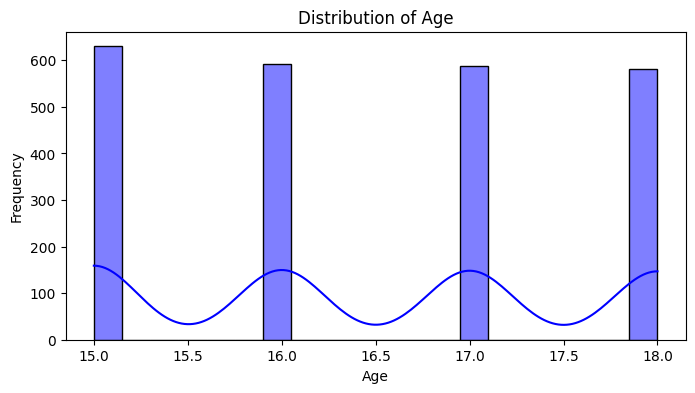

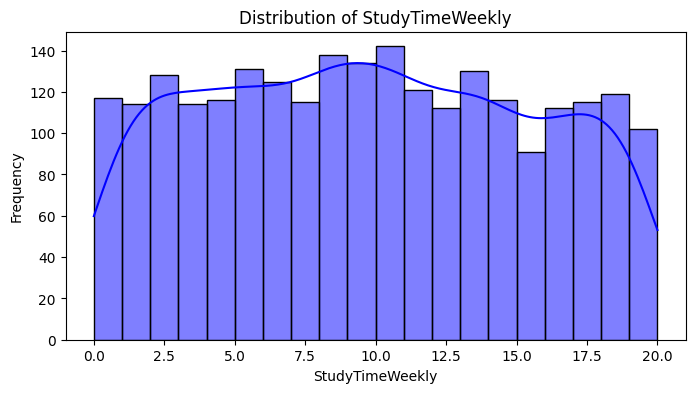

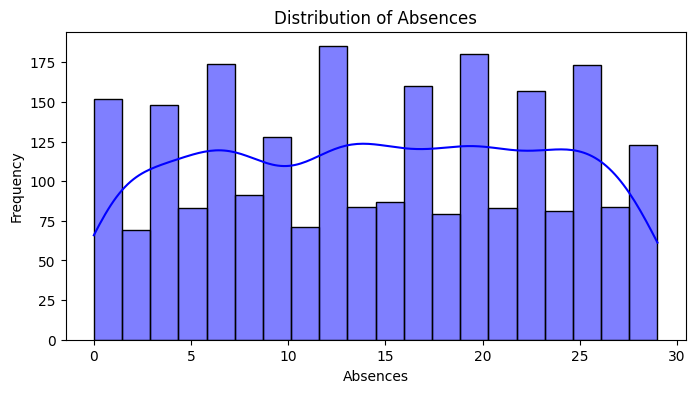

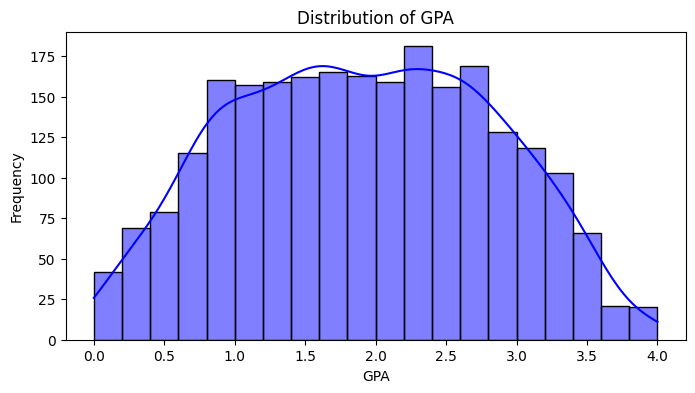

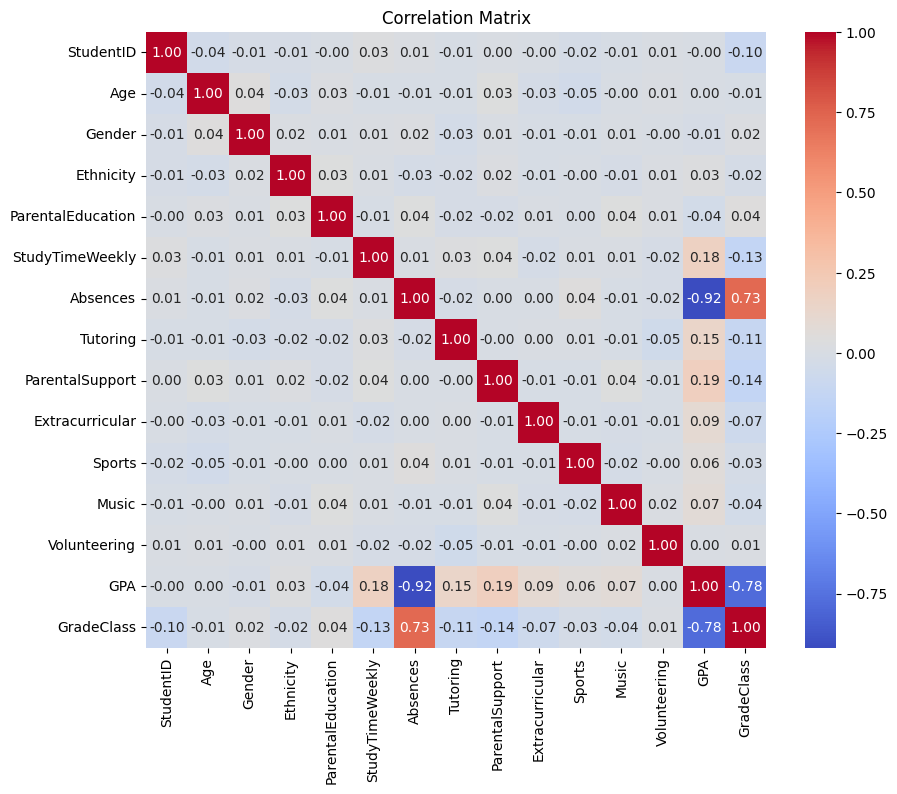

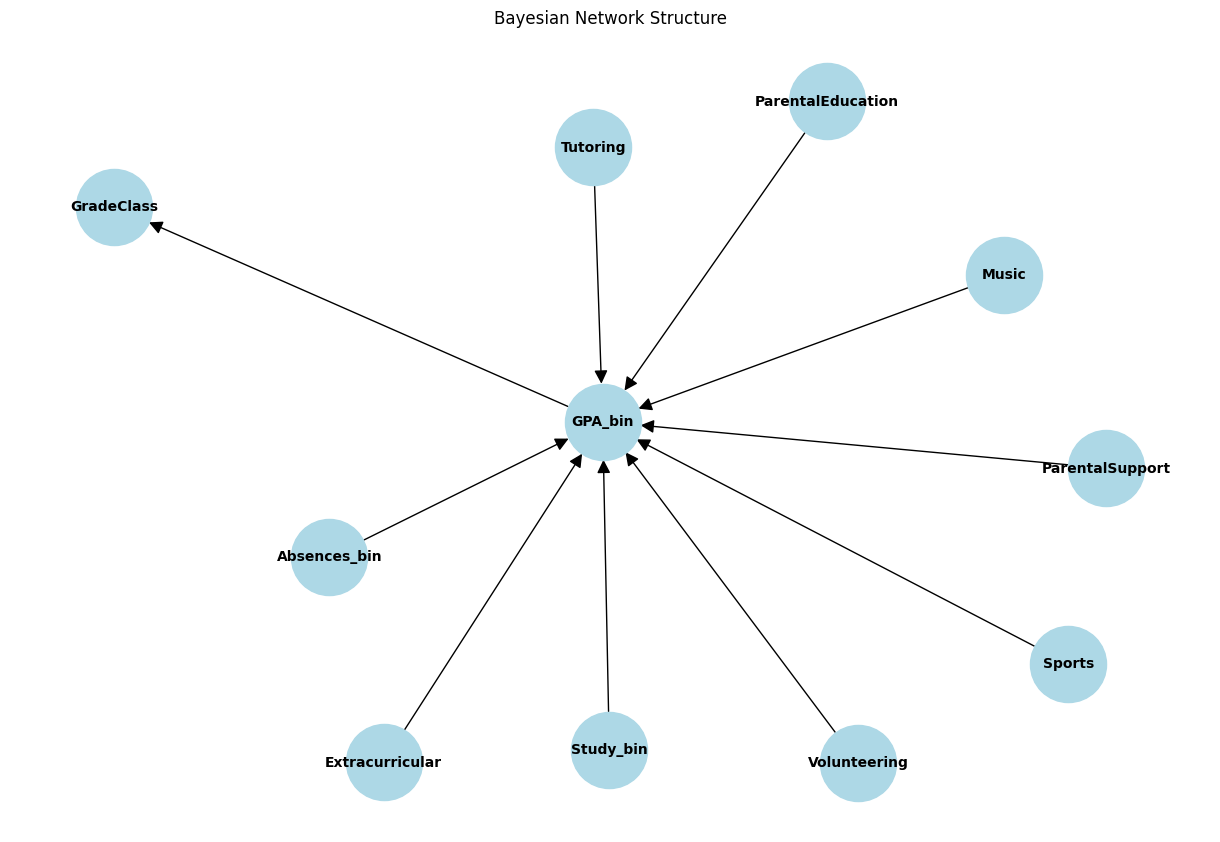

INFO:root:For GPA_bin: Used 645/1000 combinations (880 skipped)
INFO:root:For GradeClass: Used 4/4 combinations (0 skipped)
INFO:root:CPT for node Gender contains 2 entries.
INFO:root:CPT for node Ethnicity contains 4 entries.
INFO:root:CPT for node ParentalEducation contains 5 entries.
INFO:root:CPT for node Tutoring contains 2 entries.
INFO:root:CPT for node ParentalSupport contains 5 entries.
INFO:root:CPT for node Extracurricular contains 2 entries.
INFO:root:CPT for node Sports contains 2 entries.
INFO:root:CPT for node Music contains 2 entries.
INFO:root:CPT for node Volunteering contains 2 entries.
INFO:root:CPT for node Study_bin contains 4 entries.
INFO:root:CPT for node Absences_bin contains 5 entries.
INFO:root:CPT for node GPA_bin contains 645 entries.
INFO:root:CPT for node GradeClass contains 4 entries.
INFO:root:Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.
INFO:root:MAE (GPA): 0.4485209036615003
INFO:root:RMSE (GPA): 0.5907524286423096
IN

In [6]:
# Cell 1: Import libraries and set logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import logging
from itertools import product
import networkx as nx

logging.basicConfig(level=logging.INFO)

# Cell 2: Load dataset
df = pd.read_csv('data/Cleaned_Student_performance_data.csv')
logging.info(f"Dataset shape: {df.shape}")

# Cell 3: Analyze dataset
# Descriptive statistics
logging.info("Descriptive statistics:")
logging.info(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
logging.info(f"Missing values:\n{missing_values}")

# Handle missing values (if any)
df.fillna(df.median(), inplace=True)  # Replace missing values with median

# Visualize distributions of numerical features
numerical_cols = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Cell 4: Discretize continuous features
gpa_bins   = [0, 1.0, 2.0, 3.0, 4.0]
gpa_labels = ['VeryLow', 'Low', 'Medium', 'High']
df['GPA_bin'] = pd.cut(df['GPA'], bins=gpa_bins, labels=gpa_labels, include_lowest=True)

study_bins   = [0, 5, 10, 15, 20, np.inf]
study_labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
df['Study_bin'] = pd.cut(df['StudyTimeWeekly'], bins=study_bins, labels=study_labels, include_lowest=True)

abs_bins   = [0, 5, 10, 15, 20, np.inf]
abs_labels = ['None', 'Few', 'Moderate', 'High', 'VeryHigh']
df['Absences_bin'] = pd.cut(df['Absences'], bins=abs_bins, labels=abs_labels, include_lowest=True)

# Cell 5: Encode categorical variables
categorical_cols = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 
    'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Study_bin', 'Absences_bin', 'GPA_bin', 'GradeClass'
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Cell 6: Feature selection and data split
features = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Study_bin', 'Absences_bin', 
    'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering'
]
target_gpa   = 'GPA_bin'
target_class = 'GradeClass'

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[target_class]
)

# Cell 7: Define Bayesian Network structure
parents = {
    'Gender': [],
    'Ethnicity': [],
    'ParentalEducation': [],
    'Tutoring': [],
    'ParentalSupport': [],
    'Extracurricular': [],
    'Sports': [],
    'Music': [],
    'Volunteering': [],
    'Study_bin': [],
    'Absences_bin': [],
    'GPA_bin': ['Study_bin', 'ParentalEducation', 'Absences_bin', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering'],
    'GradeClass': ['GPA_bin']
}

# Visualize Bayesian Network structure
def visualize_bayesian_network(parents):
    G = nx.DiGraph()
    for child, pars in parents.items():
        for parent in pars:
            G.add_edge(parent, child)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
    plt.title("Bayesian Network Structure")
    plt.show()

visualize_bayesian_network(parents)

# Modified Cell 8: Compute Conditional Probability Tables (CPTs) with better coverage
CPT = {}

# Improved hyperparameters
laplace_smoothing = 2  # Increased smoothing for better generalization
min_data_threshold = 5  # Lower threshold to include more combinations

# For GPA_bin, use a reduced feature set to improve coverage
important_gpa_features = ['Study_bin', 'ParentalEducation', 'Absences_bin', 'Tutoring', 'ParentalSupport']
parents['GPA_bin'] = important_gpa_features  # Use only the most important features

# Create simplified version of parents for the CPT
for node, pars in parents.items():
    if not pars:
        # For nodes without parents, calculate prior probabilities
        CPT[node] = train_df[node].value_counts(normalize=True).to_dict()
    else:
        # For nodes with parents, calculate conditional probabilities
        parent_values = [train_df[p].unique() for p in pars]
        combinations = list(product(*parent_values))
        table = {}
        classes = train_df[node].unique()
        
        # Track how many combinations are skipped
        skipped_combos = 0
        total_combos = len(combinations)
        
        for combo in combinations:
            # Create a mask for the current combination of parent values
            mask = np.ones(len(train_df), dtype=bool)
            for p, v in zip(pars, combo):
                mask &= (train_df[p] == v)
            subset = train_df[mask]

            # Check if the subset has enough data points
            if len(subset) < min_data_threshold:
                skipped_combos += 1
                # For GPA_bin, we'll use a simpler model to fill gaps
                if node == 'GPA_bin' and len(subset) > 0:
                    # Even with 1 or 2 samples, still calculate probabilities
                    counts = subset[node].value_counts()
                    total = counts.sum()
                    probs = {
                        c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                        for c in classes
                    }
                    table[combo] = probs
                continue

            # Calculate counts and probabilities with Laplace smoothing
            counts = subset[node].value_counts()
            total = counts.sum()
            probs = {
                c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                for c in classes
            }
            table[combo] = probs
        
        logging.info(f"For {node}: Used {len(table)}/{total_combos} combinations ({skipped_combos} skipped)")
        CPT[node] = table

# Log the size of each CPT
for node, table in CPT.items():
    logging.info(f"CPT for node {node} contains {len(table)} entries.")

# Create simplified predictors for fallback
simplified_predictors = {}
for target in ['GPA_bin', 'GradeClass']:
    # Create simple one-feature predictors for each parent
    parent_features = parents[target]
    for feature in parent_features:
        table = {}
        for value in train_df[feature].unique():
            subset = train_df[train_df[feature] == value]
            if len(subset) > 0:
                probs = {}
                for c in train_df[target].unique():
                    count = len(subset[subset[target] == c])
                    probs[c] = (count + laplace_smoothing) / (len(subset) + laplace_smoothing * len(train_df[target].unique()))
                table[value] = probs
        simplified_predictors[(target, feature)] = table


# Cell 9: Save model to .pkl
model_data = {
    'CPT': CPT,
    'parents': parents,
    'label_encoders': label_encoders,
    'features': features,
    'target_gpa': target_gpa,
    'target_class': target_class,
    'simplified_predictors': simplified_predictors
}
joblib.dump(model_data, 'models/bayesian_model.pkl')

mean_gpa = train_df.groupby('GPA_bin')['GPA'].mean().to_dict()
joblib.dump(mean_gpa, 'models/mean_gpa.pkl')

logging.info("Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.")

# Cell 10: Define prediction functions
def predict_gpa_bin(row):
    key = tuple(row[p] for p in parents['GPA_bin'])
    if key in CPT['GPA_bin']:
        probs = CPT['GPA_bin'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GPA_bin'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

def predict_gradeclass(row):
    key = tuple(row[p] for p in parents['GradeClass'])
    if key in CPT['GradeClass']:
        probs = CPT['GradeClass'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GradeClass'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

# Cell 11: Predict and evaluate
test_df['Predicted_GPA_bin'] = test_df.apply(predict_gpa_bin, axis=1)
test_df['Predicted_GradeClass'] = test_df.apply(predict_gradeclass, axis=1)

# Evaluate GPA predictions
true_gpa = test_df['GPA']
predicted_gpa = test_df['Predicted_GPA_bin'].map(mean_gpa)
mae = mean_absolute_error(true_gpa, predicted_gpa)
rmse = np.sqrt(mean_squared_error(true_gpa, predicted_gpa))
logging.info(f"MAE (GPA): {mae}")
logging.info(f"RMSE (GPA): {rmse}")

# Evaluate GradeClass predictions
accuracy = accuracy_score(test_df['GradeClass'], test_df['Predicted_GradeClass'])
logging.info(f"Accuracy (GradeClass): {accuracy}")

# Cell 12: Save evaluation metrics
evaluation_metrics = {
    'MAE_GPA': mae,
    'RMSE_GPA': rmse,
    'Accuracy_GradeClass': accuracy
}
joblib.dump(evaluation_metrics, 'models/evaluation_metrics.pkl')
logging.info("Evaluation metrics saved successfully.")

In [7]:
# Advanced Bayesian Network Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import networkx as nx
from networkx.algorithms import community
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

# 1. Enhanced Bayesian Network Visualization
print("\n--- ENHANCED BAYESIAN NETWORK VISUALIZATION ---")
plt.figure(figsize=(15, 10))

# Create a directed graph
G = nx.DiGraph()
# Add all nodes
for node in parents.keys():
    G.add_node(node)
# Add edges according to the structure
for child, pars in parents.items():
    for parent in pars:
        G.add_edge(parent, child)

# Use hierarchical layout
pos = nx.spring_layout(G, seed=42, k=0.5)

# Node categories for coloring
node_categories = {
    'Input Features': ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 
                      'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Study_bin', 'Absences_bin'],
    'Target Variables': ['GPA_bin', 'GradeClass']
}

# Assign colors for each category
colors = {'Input Features': '#66c2a5', 'Target Variables': '#fc8d62'}
node_colors = []
for node in G.nodes():
    for category, nodes in node_categories.items():
        if node in nodes:
            node_colors.append(colors[category])
            break
    else:
        node_colors.append('#8da0cb')  # Default color

# Draw the network
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                             markersize=15, label=category) 
                   for category, color in colors.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Bayesian Network Structure for Student Performance Prediction', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Visualizing CPT Distribution
print("\n--- CONDITIONAL PROBABILITY TABLES VISUALIZATION ---")
# Focus on the important nodes
important_nodes = ['GPA_bin', 'GradeClass']
for node in important_nodes:
    if node in CPT and isinstance(CPT[node], dict) and len(CPT[node]) > 0:
        print(f"\nCPT Analysis for {node}:")
        
        # For nodes with parents, visualize the distribution of conditional probabilities
        if parents[node]:
            # Take a sample of CPTs if there are too many
            max_samples = 10
            samples = list(CPT[node].keys())[:max_samples] if len(CPT[node]) > max_samples else list(CPT[node].keys())
            
            # Get class labels for this node
            classes = sorted(list(next(iter(CPT[node].values())).keys()))
            num_classes = len(classes)
            
            # Create a DataFrame to visualize the probability distributions
            sample_names = [f"Case {i+1}" for i in range(len(samples))]
            prob_df = pd.DataFrame(index=sample_names, columns=classes)
            
            for i, key in enumerate(samples):
                prob_df.iloc[i] = [CPT[node][key].get(cls, 0) for cls in classes]
            
            plt.figure(figsize=(12, 7))
            sns.heatmap(prob_df, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Probability'})
            plt.title(f'Conditional Probability Distribution for {node}', fontsize=14)
            plt.xlabel('Class Values')
            plt.ylabel('Parent Value Combinations')
            plt.tight_layout()
            plt.show()
            
            # Also show the actual parent combinations for these samples
            parent_df = pd.DataFrame(index=sample_names, columns=parents[node])
            for i, key in enumerate(samples):
                for j, parent in enumerate(parents[node]):
                    # Get original label for readability if possible
                    label_encoder = label_encoders.get(parent)
                    if label_encoder:
                        try:
                            parent_df.iloc[i, j] = label_encoder.inverse_transform([key[j]])[0]
                        except:
                            parent_df.iloc[i, j] = key[j]
                    else:
                        parent_df.iloc[i, j] = key[j]
            
            print("Sample parent combinations:")
            display(parent_df)

# 3. Naive Bayes Classifier Implementation
print("\n--- NAIVE BAYES CLASSIFIER IMPLEMENTATION ---")
# Implementing Naive Bayes classifier for comparison
X_train = train_df[features].values
y_train_gpa = train_df[target_gpa].values
y_train_class = train_df[target_class].values

X_test = test_df[features].values
y_test_gpa = test_df[target_gpa].values
y_test_class = test_df[target_class].values

# Train Naive Bayes for GPA and Grade Class prediction
nb_gpa = MultinomialNB()
nb_gpa.fit(X_train, y_train_gpa)
nb_grade = MultinomialNB()
nb_grade.fit(X_train, y_train_class)

# Predict
nb_gpa_pred = nb_gpa.predict(X_test)
nb_class_pred = nb_grade.predict(X_test)

# Calculate metrics
nb_gpa_accuracy = accuracy_score(y_test_gpa, nb_gpa_pred)
nb_class_accuracy = accuracy_score(y_test_class, nb_class_pred)

# Get probabilistic prediction for GPA
nb_gpa_probs = nb_gpa.predict_proba(X_test)

# Print results
print(f"Naive Bayes GPA Bin Accuracy: {nb_gpa_accuracy:.4f}")
print(f"Naive Bayes Grade Class Accuracy: {nb_class_accuracy:.4f}")

# Get Naive Bayes confusion matrix for GPA bin
gpa_cm = confusion_matrix(y_test_gpa, nb_gpa_pred)
gpa_labels = [label_encoders[target_gpa].inverse_transform([i])[0] for i in range(len(label_encoders[target_gpa].classes_))]

plt.figure(figsize=(10, 8))
sns.heatmap(gpa_cm, annot=True, fmt='d', cmap='Blues', xticklabels=gpa_labels, yticklabels=gpa_labels)
plt.title('Confusion Matrix for GPA Bin Prediction (Naive Bayes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Analysis of Feature Importance using Information Gain
print("\n--- FEATURE IMPORTANCE ANALYSIS ---")
# Calculate mutual information between features and targets
mi_gpa = mutual_info_classif(df[features], df[target_gpa], discrete_features=True, random_state=42)
mi_class = mutual_info_classif(df[features], df[target_class], discrete_features=True, random_state=42)

# Create dataframes for visualization
mi_df_gpa = pd.DataFrame({'Feature': features, 'Importance for GPA': mi_gpa})
mi_df_class = pd.DataFrame({'Feature': features, 'Importance for Grade Class': mi_class})

# Sort by importance
mi_df_gpa = mi_df_gpa.sort_values('Importance for GPA', ascending=False)
mi_df_class = mi_df_class.sort_values('Importance for Grade Class', ascending=False)

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# For GPA
sns.barplot(x='Importance for GPA', y='Feature', data=mi_df_gpa, ax=ax1, palette='viridis')
ax1.set_title('Feature Importance for GPA Prediction', fontsize=14)
ax1.set_xlabel('Mutual Information Score')
ax1.set_ylabel('Feature')

# For Grade Class
sns.barplot(x='Importance for Grade Class', y='Feature', data=mi_df_class, ax=ax2, palette='viridis')
ax2.set_title('Feature Importance for Grade Class Prediction', fontsize=14)
ax2.set_xlabel('Mutual Information Score')
ax2.set_ylabel('Feature')

plt.tight_layout()
plt.show()

# 5. Sensitivity Analysis
print("\n--- SENSITIVITY ANALYSIS ---")
# We'll perform a sensitivity analysis by varying the values of the most important features
# and seeing how they affect the predicted outcomes

# Identify top 3 important features
top_features_gpa = mi_df_gpa.head(3)['Feature'].tolist()
print(f"Top features for GPA prediction: {top_features_gpa}")

# Create a baseline student profile (average/median values)
baseline_student = {}
for feature in features:
    baseline_student[feature] = int(train_df[feature].median())

# Function to predict GPA based on varying feature values
def predict_with_varying_feature(feature, baseline_student):
    unique_values = sorted(train_df[feature].unique())
    predicted_gpas = []
    
    for value in unique_values:
        # Create a copy of the baseline student
        student = baseline_student.copy()
        # Update the feature value
        student[feature] = value
        # Create a dataframe with this student
        student_df = pd.DataFrame([student])
        # Predict GPA bin
        gpa_bin = predict_gpa_bin(student_df.iloc[0])
        # Convert to numeric GPA
        num_gpa = mean_gpa[gpa_bin]
        predicted_gpas.append(num_gpa)
    
    # Convert feature values to original labels when possible
    label_encoder = label_encoders.get(feature)
    if label_encoder and len(unique_values) == len(label_encoder.classes_):
        labels = [label_encoder.inverse_transform([val])[0] for val in unique_values]
    else:
        labels = [str(val) for val in unique_values]
        
    return labels, predicted_gpas

# Plot sensitivity for top features
fig, axes = plt.subplots(1, len(top_features_gpa), figsize=(18, 6))

for i, feature in enumerate(top_features_gpa):
    labels, predicted_gpas = predict_with_varying_feature(feature, baseline_student)
    
    # Convert to more readable labels if possible
    axes[i].plot(labels, predicted_gpas, marker='o', markersize=10, linewidth=2)
    axes[i].set_title(f'Effect of {feature} on GPA')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Predicted GPA')
    
    # Add grid
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels if there are many
    if len(labels) > 5:
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 6. Clustering Students Based on Profile
print("\n--- STUDENT CLUSTERING ANALYSIS ---")
# We'll use K-means to cluster students based on their features
# and analyze performance within each cluster

# Standardize features for clustering
scaler = StandardScaler()
cluster_features = features.copy()
scaled_features = scaler.fit_transform(df[cluster_features])

# Determine optimal number of clusters using silhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 7)  # Try between 2 and 6 clusters

for k in k_range:
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, silhouette score = {silhouette_avg:.3f}")

# Find the best number of clusters
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters: {best_k}")

# Perform clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze GPA distribution across clusters
plt.figure(figsize=(14, 7))
sns.boxplot(x='cluster', y='GPA', data=df, palette='Set3')
plt.title('GPA Distribution Across Student Clusters', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('GPA')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analyze cluster profiles
cluster_profiles = df.groupby('cluster')[features + ['GPA']].mean()
print("\nCluster Profiles:")
display(cluster_profiles)

# Heatmap of cluster profiles
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_profiles, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Cluster Profiles', fontsize=14)
plt.tight_layout()
plt.show()

# 7. Generate Recommendations Based on Model
print("\n--- PERSONALIZED RECOMMENDATIONS BASED ON BAYESIAN NETWORK ---")

def generate_recommendations(student_profile):
    """Generate recommendations to improve GPA for a student profile."""
    
    # Convert profile to proper format if needed
    if isinstance(student_profile, pd.Series):
        student = student_profile.to_dict()
    else:
        student = student_profile.copy()
    
    # Create a baseline for comparison
    baseline_gpa_bin = predict_gpa_bin(student)
    baseline_gpa = mean_gpa[baseline_gpa_bin]
    
    print(f"Current predicted GPA: {baseline_gpa:.2f}")
    
    # Identify actionable features that can be improved
    actionable_features = ['Study_bin', 'Absences_bin', 'Tutoring', 
                          'ParentalSupport', 'Extracurricular']
    
    improvements = []
    
    for feature in actionable_features:
        # Get current value
        current_value = student[feature]
        
        # Try different values for this feature
        unique_values = sorted(train_df[feature].unique())
        best_gpa = baseline_gpa
        best_value = current_value
        
        for value in unique_values:
            if value != current_value:
                # Create modified student profile
                modified_student = student.copy()
                modified_student[feature] = value
                
                # Predict new GPA
                new_gpa_bin = predict_gpa_bin(modified_student)
                new_gpa = mean_gpa[new_gpa_bin]
                
                # Check if this improves the GPA
                if new_gpa > best_gpa:
                    best_gpa = new_gpa
                    best_value = value
        
        # If we found an improvement
        if best_value != current_value:
            # Try to get human-readable labels
            if feature in label_encoders:
                current_label = label_encoders[feature].inverse_transform([current_value])[0]
                target_label = label_encoders[feature].inverse_transform([best_value])[0]
            else:
                current_label = str(current_value)
                target_label = str(best_value)
                
            improvement = {
                'feature': feature,
                'current': current_label,
                'target': target_label,
                'gpa_improvement': best_gpa - baseline_gpa
            }
            improvements.append(improvement)
    
    # Sort improvements by impact
    improvements.sort(key=lambda x: x['gpa_improvement'], reverse=True)
    
    return improvements

# Example: Generate recommendations for an average-performing student
sample_student = test_df.iloc[10]
print(f"Sample student current GPA: {sample_student['GPA']:.2f}")

recommendations = generate_recommendations(sample_student)
print("\nTop Recommendations:")
for i, rec in enumerate(recommendations[:3], 1):  # Show top 3 recommendations
    print(f"{i}. Improve {rec['feature']} from {rec['current']} to {rec['target']} " + 
          f"(Potential GPA increase: {rec['gpa_improvement']:.2f})")

# 8. Overall Model Evaluation and Comparison
print("\n--- MODEL EVALUATION AND COMPARISON ---")

# Calculate various metrics
bayesian_gpa_acc = accuracy_score(test_df[target_gpa], test_df['Predicted_GPA_bin'])
bayesian_class_acc = accuracy_score(test_df[target_class], test_df['Predicted_GradeClass'])

bayesian_gpa_f1 = f1_score(test_df[target_gpa], test_df['Predicted_GPA_bin'], average='weighted')
bayesian_class_f1 = f1_score(test_df[target_class], test_df['Predicted_GradeClass'], average='weighted')

nb_gpa_f1 = f1_score(y_test_gpa, nb_gpa_pred, average='weighted')
nb_class_f1 = f1_score(y_test_class, nb_class_pred, average='weighted')

# Create a comparison DataFrame
comparison_data = {
    'Metric': ['Accuracy (%)', 'F1-Score'],
    'Bayesian Network - GPA': [bayesian_gpa_acc*100, bayesian_gpa_f1*100],
    'Naive Bayes - GPA': [nb_gpa_accuracy*100, nb_gpa_f1*100],
    'Bayesian Network - Grade Class': [bayesian_class_acc*100, bayesian_class_f1*100],
    'Naive Bayes - Grade Class': [nb_class_accuracy*100, nb_class_f1*100]
}

comparison_df = pd.DataFrame(comparison_data)

# Set up figure
fig, ax = plt.subplots(figsize=(12, 6))

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create table
table = ax.table(
    cellText=comparison_df.values.round(2),
    colLabels=comparison_df.columns,
    cellLoc='center',
    loc='center',
    cellColours=[['#f2f2f2']*len(comparison_df.columns)]*len(comparison_df),
    colColours=['#4472C4'] * len(comparison_df.columns)
)

# Modify table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Add a title
plt.suptitle('Model Performance Comparison', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Display model performance metrics
print("\nModel Performance Summary:")
print(f"MAE (GPA): {mae:.4f}")
print(f"RMSE (GPA): {rmse:.4f}")
print(f"Accuracy (GradeClass): {accuracy*100:.2f}%")

# 9. Interactive Visualization (if in Jupyter environment)
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Create interactive feature importance visualization
    fig = make_subplots(rows=1, cols=2, 
                        subplot_titles=("Feature Importance for GPA Prediction", 
                                        "Feature Importance for Grade Class Prediction"))

    # GPA Feature Importance
    fig.add_trace(
        go.Bar(
            y=mi_df_gpa['Feature'],
            x=mi_df_gpa['Importance for GPA'],
            orientation='h',
            marker=dict(color='rgba(58, 71, 80, 0.6)', line=dict(color='rgba(58, 71, 80, 1.0)', width=3)),
            name='GPA Importance'
        ),
        row=1, col=1
    )

    # Grade Class Feature Importance
    fig.add_trace(
        go.Bar(
            y=mi_df_class['Feature'],
            x=mi_df_class['Importance for Grade Class'],
            orientation='h',
            marker=dict(color='rgba(246, 78, 139, 0.6)', line=dict(color='rgba(246, 78, 139, 1.0)', width=3)),
            name='Grade Class Importance'
        ),
        row=1, col=2
    )

    fig.update_layout(
        title_text="Interactive Feature Importance Analysis", 
        height=600,
        showlegend=False
    )
    
    # Display interactive plot
    fig.show()
    
    # Create an interactive confusion matrix for Bayesian Network GPA prediction
    test_df['Actual_GPA_bin_label'] = test_df[target_gpa].apply(lambda x: label_encoders[target_gpa].inverse_transform([x])[0])
    test_df['Predicted_GPA_bin_label'] = test_df['Predicted_GPA_bin'].apply(lambda x: label_encoders[target_gpa].inverse_transform([x])[0])
    
    gpa_confusion = pd.crosstab(test_df['Actual_GPA_bin_label'], test_df['Predicted_GPA_bin_label'])
    
    # Normalize the confusion matrix
    gpa_confusion_norm = gpa_confusion.div(gpa_confusion.sum(axis=1), axis=0)
    
    # Create heatmap
    fig = px.imshow(
        gpa_confusion_norm, 
        labels=dict(x="Predicted GPA Bin", y="Actual GPA Bin", color="Proportion"),
        x=gpa_confusion_norm.columns,
        y=gpa_confusion_norm.index,
        text_auto='.2f',
        color_continuous_scale='Blues'
    )
    
    fig.update_layout(
        title='Confusion Matrix for GPA Bin Prediction (Bayesian Network)',
        height=600
    )
    
    fig.show()

except:
    print("Interactive visualization requires Plotly and a Jupyter-compatible environment.")

ModuleNotFoundError: No module named 'plotly'